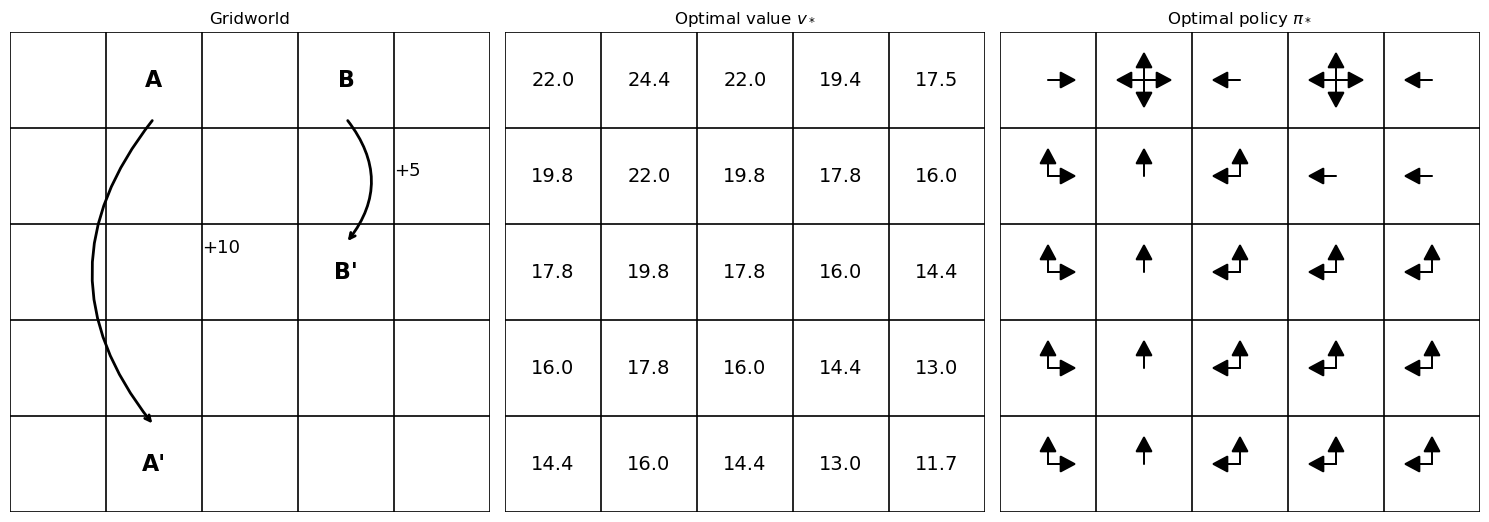

In [26]:
#Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Fgure 3.5 and 4.1
# Value iteration and Policy iteration 
# i used numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt

#figure 3.5
# environment class
class SimplifiedGridworldEnvironment:
    def __init__(self, world_size=5):
        self.world_size = world_size
        self.special_location_a = (0, 1)
        self.special_exit_a = (4, 1)
        self.special_reward_a = 10
        self.special_location_b = (0, 3)
        self.special_exit_b = (2, 3)
        self.special_reward_b = 5
        self.movement_directions = {
            'north': (-1, 0),
            'south': (1, 0),
            'east': (0, 1),
            'west': (0, -1)
        }
        self.available_actions = list(self.movement_directions.keys())
    def compute_transition(self, current_row, current_col, chosen_action):
        if (current_row, current_col) == self.special_location_a:
            return (self.special_exit_a[0], self.special_exit_a[1], self.special_reward_a)
        if (current_row, current_col) == self.special_location_b:
            return (self.special_exit_b[0], self.special_exit_b[1], self.special_reward_b)
        row_change, col_change = self.movement_directions[chosen_action]
        resulting_row = current_row + row_change
        resulting_col = current_col + col_change
        if (resulting_row < 0 or resulting_row >= self.world_size or 
            resulting_col < 0 or resulting_col >= self.world_size):
            resulting_row = current_row
            resulting_col = current_col
            immediate_reward = -1
        else:
            immediate_reward = 0
        return resulting_row, resulting_col, immediate_reward

def run_value_iteration(env, discount, tolerance=1e-4, max_iters=1000):
    state_values = np.zeros((env.world_size, env.world_size))
    for _ in range(max_iters):
        update_delta = 0
        next_values = np.zeros_like(state_values)
        for row in range(env.world_size):
            for col in range(env.world_size):
                best_action_value = float('-inf')
                for action in env.available_actions:
                    next_row, next_col, reward = env.compute_transition(row, col, action)
                    candidate_value = reward + discount * state_values[next_row, next_col]
                    if candidate_value > best_action_value:
                        best_action_value = candidate_value
                next_values[row, col] = best_action_value
                update_delta = max(update_delta, abs(best_action_value - state_values[row, col]))
        state_values = next_values
        if update_delta < tolerance:
            break
    return state_values

def extract_optimal_policy_with_ties(env, state_values, discount):
    # returns dict mapping each state to list of optimal actions (accounts for ties)
    optimal_policy = {}
    for row in range(env.world_size):
        for col in range(env.world_size):
            action_returns = {}
            for action in env.available_actions:
                next_row, next_col, reward = env.compute_transition(row, col, action)
                action_returns[action] = reward + discount * state_values[next_row, next_col]
            max_q = max(action_returns.values())
            best_actions = [a for a, v in action_returns.items() if abs(v - max_q) < 1e-8]
            optimal_policy[(row, col)] = best_actions
    return optimal_policy

def plot_gridworld_diagram(ax, env):
    # draw grid and special transitions (A, B, arrows, rewards)
    for i in range(env.world_size + 1):
        ax.axhline(i, color='black', linewidth=1.2)
        ax.axvline(i, color='black', linewidth=1.2)
    # label A, B, A', B'
    ax.text(1.5, 4.5, "A", ha="center", va="center", fontsize=16, fontweight="bold")
    ax.text(3.5, 4.5, "B", ha="center", va="center", fontsize=16, fontweight="bold")
    ax.text(1.5, 0.5, "A'", ha="center", va="center", fontsize=16, fontweight="bold")
    ax.text(3.5, 2.5, "B'", ha="center", va="center", fontsize=16, fontweight="bold")
    # arrows
    ax.annotate('', xy=(1.5,0.9), xytext=(1.5,4.1),
                arrowprops=dict(arrowstyle='->',lw=2,connectionstyle="arc3,rad=0.4"))
    ax.text(2, 2.7, '+10', fontsize=13)
    ax.annotate('', xy=(3.5,2.8), xytext=(3.5,4.1),
                arrowprops=dict(arrowstyle='->',lw=2,connectionstyle="arc3,rad=-0.4"))
    ax.text(4,3.5, '+5', fontsize=13)
    ax.set_xlim(0,env.world_size)
    ax.set_ylim(0,env.world_size)
    ax.set_aspect('equal')
    ax.axis('off')

def plot_values_on_grid(ax, values, env):
    for i in range(env.world_size + 1):
        ax.axhline(i, color='black', linewidth=1.2)
        ax.axvline(i, color='black', linewidth=1.2)
    for row in range(env.world_size):
        for col in range(env.world_size):
            v = values[row, col]
            x = col + 0.5
            y = env.world_size - row - 0.5
            ax.text(x, y, f"{v:4.1f}", ha='center', va='center', fontsize=14)
    ax.set_xlim(0,env.world_size)
    ax.set_ylim(0,env.world_size)
    ax.set_aspect('equal')
    ax.axis('off')

def plot_policy_arrows_on_grid(ax, policy, env):
    arrow_defs = {
        'north': (0, 0.28),
        'south': (0, -0.28),
        'east': (0.28, 0),
        'west': (-0.28, 0)
    }
    arrow_head = dict(head_width=0.16, head_length=0.15, lw=1.2, fc='black', ec='black', length_includes_head=True)
    for i in range(env.world_size + 1):
        ax.axhline(i, color='black', linewidth=1.2)
        ax.axvline(i, color='black', linewidth=1.2)
    for row in range(env.world_size):
        for col in range(env.world_size):
            acts = policy[(row,col)]
            x = col + 0.5
            y = env.world_size - row - 0.5
            for a in acts:
                dx, dy = arrow_defs[a]
                ax.arrow(x, y, dx, dy, **arrow_head)
    ax.set_xlim(0,env.world_size)
    ax.set_ylim(0,env.world_size)
    ax.set_aspect('equal')
    ax.axis('off')


def plot_figure_3_5(env, values, policy_with_ties):
    fig, axs = plt.subplots(1,3,figsize=(15,6))
    plot_gridworld_diagram(axs[0], env)
    plot_values_on_grid(axs[1], values, env)
    plot_policy_arrows_on_grid(axs[2], policy_with_ties, env)
    axs[0].set_title("Gridworld")
    axs[1].set_title(r"Optimal value $v_*$")
    axs[2].set_title(r"Optimal policy $\pi_*$")
    plt.tight_layout()
    plt.show()
    

def value_iteration_snapshots(env, discount, iteration_list):
    # holds (iteration step, value_table) pairs for requested iterations
    state_values = np.zeros((env.world_size, env.world_size))
    value_history = []
    max_iters = max(iteration_list)
    for curr_iter in range(max_iters+1):
        next_values = np.zeros_like(state_values)
        for row in range(env.world_size):
            for col in range(env.world_size):
                q_values = []
                for action in env.available_actions:
                    next_row, next_col, reward = env.compute_transition(row, col, action)
                    q = reward + discount * state_values[next_row, next_col]
                    q_values.append(q)
                next_values[row, col] = max(q_values)
        state_values = next_values
        if curr_iter in iteration_list:
            value_history.append((curr_iter, state_values.copy()))
    return value_history

def extract_greedy_policy_with_ties(env, state_values, discount):
    # maps each state to a list of optimal actions (for ties)
    policy = {}
    for row in range(env.world_size):
        for col in range(env.world_size):
            action_values = {}
            for action in env.available_actions:
                next_row, next_col, reward = env.compute_transition(row, col, action)
                action_values[action] = reward + discount * state_values[next_row, next_col]
            best_val = max(action_values.values())
            optimal_actions = [a for a,v in action_values.items() if abs(v - best_val) < 1e-8]
            policy[(row, col)] = optimal_actions
    return policy



# run main
if __name__ == "__main__":
    env = SimplifiedGridworldEnvironment(world_size=5)
    discount = 0.9
    values = run_value_iteration(env, discount)
    policy_with_ties = extract_optimal_policy_with_ties(env, values, discount)
    plot_figure_3_5(env, values, policy_with_ties)
    


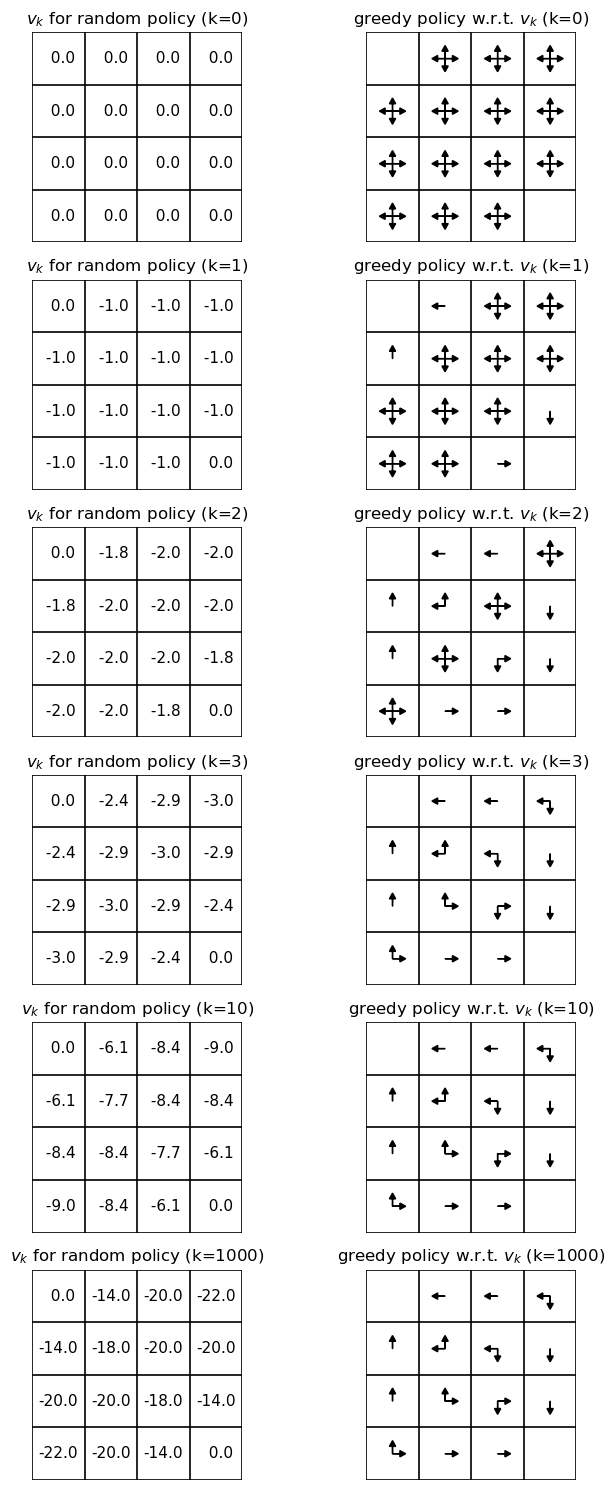

In [ ]:
# Niveen Abdul-Mohsen (bvn9ad)
# reinforcement learning (cs 4771) - figure 4.1
# policy evaluation convergence on gridworld with terminal states
# uses numpy for computation and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt

class simplifiedGridWorldEnvironment:
    """4x4 gridworld with terminal states at corners (0,0) and (3,3)"""
    def __init__(self, size=4):
        self.size = size
        self.terminal_states = [(0, 0), (3, 3)]
        self.actions = ['north', 'south', 'east', 'west']
        self.deltas = {
            'north': (-1, 0),
            'south': (1, 0),
            'east': (0, 1),
            'west': (0, -1)
        }
    
    def is_terminal(self, r, c):
        """check if state is terminal"""
        return (r, c) in self.terminal_states
    
    def transition(self, r, c, action):
        """returns next state and reward"""
        # terminal states have no transitions
        if self.is_terminal(r, c):
            return r, c, 0
        
        dr, dc = self.deltas[action]
        nr, nc = r + dr, c + dc
        
        # check boundaries
        if nr < 0 or nr >= self.size or nc < 0 or nc >= self.size:
            # stay in same state with -1 reward
            return r, c, -1
        
        # all transitions have reward -1
        return nr, nc, -1

def policy_evaluation_with_terminals(gridworld, discount, iteration_list):
    """evaluate equiprobable random policy with terminal states"""
    V = np.zeros((gridworld.size, gridworld.size))
    value_history = []
    
    # store k=0 (initial values all zeros)
    if 0 in iteration_list:
        value_history.append((0, V.copy()))
    
    # iterate and store snapshots
    for k in range(1, max(iteration_list) + 1):
        V_new = np.zeros_like(V)
        for r in range(gridworld.size):
            for c in range(gridworld.size):
                # terminal states always have value 0
                if gridworld.is_terminal(r, c):
                    V_new[r, c] = 0
                    continue
                
                val = 0
                # random policy: each action has probability 0.25
                for action in gridworld.actions:
                    nr, nc, reward = gridworld.transition(r, c, action)
                    val += 0.25 * (reward + discount * V[nr, nc])
                V_new[r, c] = val
        V = V_new
        if k in iteration_list:
            value_history.append((k, V.copy()))
    
    return value_history

def extract_greedy_policy_with_ties(gridworld, values, discount):
    """extract greedy policy from value function"""
    policy = {}
    for r in range(gridworld.size):
        for c in range(gridworld.size):
            # terminal states have no actions
            if gridworld.is_terminal(r, c):
                policy[(r, c)] = []
                continue
            
            action_vals = {}
            for action in gridworld.actions:
                nr, nc, reward = gridworld.transition(r, c, action)
                action_vals[action] = reward + discount * values[nr, nc]
            best_q = max(action_vals.values())
            best_actions = [a for a, q in action_vals.items() if abs(q - best_q) < 1e-8]
            policy[(r, c)] = best_actions
    return policy

def plot_value_and_policy_grids(ax_val, ax_pi, values, policy, gridworld):
    """plot value grid (left) and policy arrows (right)"""
    size = gridworld.size
    
    # draw value grid
    for i in range(size + 1):
        ax_val.axhline(i, color='black', lw=1.2)
        ax_val.axvline(i, color='black', lw=1.2)
    for r in range(size):
        for c in range(size):
            x, y = c + 0.5, size - r - 0.5
            ax_val.text(x, y, f"{values[r, c]:5.1f}", ha='center', va='center', fontsize=11)
    ax_val.set_xlim(0, size)
    ax_val.set_ylim(0, size)
    ax_val.set_aspect('equal')
    ax_val.axis('off')
    
    # draw policy grid with arrows
    arrow_defs = {'north':(0,0.25),'south':(0,-0.25),'east':(0.25,0),'west':(-0.25,0)}
    arrowprops = dict(head_width=0.12, head_length=0.11, lw=1.0, fc='black', ec='black', length_includes_head=True)
    for i in range(size + 1):
        ax_pi.axhline(i, color='black', lw=1.2)
        ax_pi.axvline(i, color='black', lw=1.2)
    for r in range(size):
        for c in range(gridworld.size):
            x, y = c + 0.5, size - r - 0.5
            for a in policy[(r, c)]:
                dx, dy = arrow_defs[a]
                ax_pi.arrow(x, y, dx, dy, **arrowprops)
    ax_pi.set_xlim(0, size)
    ax_pi.set_ylim(0, size)
    ax_pi.set_aspect('equal')
    ax_pi.axis('off')

def plot_figure_4_1_complete(gridworld, value_history, discount):
    """create complete figure 4.1 with all snapshots"""
    n = len(value_history)
    fig, axs = plt.subplots(n, 2, figsize=(8, 2.5*n))
    if n == 1:
        axs = axs.reshape(1, -1)
    
    for idx, (k, values) in enumerate(value_history):
        policy = extract_greedy_policy_with_ties(gridworld, values, discount)
        plot_value_and_policy_grids(axs[idx,0], axs[idx,1], values, policy, gridworld)
        axs[idx,0].set_title(f"$v_k$ for random policy (k={k})", fontsize=12)
        axs[idx,1].set_title(f"greedy policy w.r.t. $v_k$ (k={k})", fontsize=12)
    
    plt.tight_layout()
    plt.show()

# main
if __name__ == "__main__":
    gridworld = simplifiedGridWorldEnvironment(size=4)
    discount = 1.0 #basically no discoutn for this figure
    # textbook shows k=0,1,2,3,10 and converged (k=∞≈1000)
    iteration_list = [0, 1, 2, 3, 10, 1000]
    value_history = policy_evaluation_with_terminals(gridworld, discount, iteration_list)
    plot_figure_4_1_complete(gridworld, value_history, discount)
